In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import (
    confusion_matrix, roc_curve, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, log_loss, brier_score_loss,
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, mean_absolute_percentage_error,
    matthews_corrcoef, cohen_kappa_score, jaccard_score, hamming_loss
)
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import lightgbm as lgb
from timeit import default_timer as timer
from tabulate import tabulate

In [3]:
## UDF to pull search results
def search_results(search_object, top_n=None):
    # Get the results DataFrame
    results = pd.DataFrame(search_object.cv_results_)
    
    # Remove rows with NaN mean_test_score
    results = results.dropna(subset=['mean_test_score'])
    
    # Sort by mean_test_score in descending order
    results = results.sort_values('mean_test_score', ascending=False)
    
    # Add a new 'rank' column
    results['rank'] = range(1, len(results) + 1)
    
    # Select the top N results (or all if top_n is None)
    if top_n is not None:
        top_results = results.head(top_n)
    else:
        top_results = results
    
    # Get the best parameters
    if hasattr(search_object, 'best_params_'):
        best_params = search_object.best_params_
    else:
        best_params = search_object.best_estimator_.get_params()
    
    param_names = [param.replace('classifier__', '') for param in best_params.keys()]
    
    # Create a new df with desired columns
    chart_data = pd.DataFrame()
    chart_data['rank'] = top_results['rank']
    chart_data['target'] = top_results['mean_test_score'].round(4)
    
    # Add columns for each parameter, removing 'classifier__' prefix
    for param in best_params.keys():
        clean_param = param.replace('classifier__', '')
        chart_data[clean_param] = top_results['params'].apply(lambda x: x[param])
    
    # Convert to a list of lists for tabulate
    table_data = chart_data.values.tolist()
    
    # Create headers
    headers = ['rank', 'target'] + param_names
    
    # Create the table
    table = tabulate(table_data, headers=headers, tablefmt='pipe', floatfmt='.4f')
    
    # Add the best result information, removing 'classifier__' prefix
    best_params_str = '; '.join([f"{k.replace('classifier__', '')}={v}" for k, v in best_params.items()])
    best_score = search_object.best_score_
    table += f"\nBest result: {{{best_params_str}}}; f(x) = {best_score:.4f}."
    
    # Add information about failed iterations
    total_iters = len(search_object.cv_results_['mean_test_score'])
    failed_iters = np.isnan(search_object.cv_results_['mean_test_score']).sum()
    if failed_iters > 0:
        table += f"\nNote: {failed_iters} out of {total_iters} iterations failed to produce valid results."
    
    return table

In [4]:
data = pd.read_csv('C:/Users/tyler/Downloads/Clunker_Dat.csv', header=0)
data = pd.DataFrame(data)
#data = data.dropna()
print(data.shape)
print(list(data.columns))

(40516, 36)
['IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'QualityCode', 'ID', 'VehOdo + rand_num']


In [5]:
data.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,QualityCode,ID,VehOdo + rand_num
0,0,2009-08-19,ADESA,2007,2,DODGE,CHARGER V6 2.7L V6 M,Bas,4D SEDAN 2.7L,SILVER,...,NaN,17675,20166,VA,10315.0,0,975,DY,100,47663
1,0,2009-10-13,ADESA,2004,5,PONTIAC,GRAND PRIX 3.8L V6 S,GT,4D SEDAN GT,MAROON,...,NaN,99740,50111,IA,5310.0,0,2152,QZ,300,84501
2,1,2010-11-11,ADESA,2005,5,CHRYSLER,PT CRUISER,GT,2D CONVERTIBLE DREAM CRUISER,GREY,...,NaN,17212,72117,AR,4710.0,0,1506,KZ,400,72570
3,0,2010-06-25,ADESA,2001,9,CHEVROLET,IMPALA,Bas,4D SEDAN,WHITE,...,NaN,5546,34203,FL,3925.0,0,2003,UE,600,65330
4,0,2009-09-29,ADESA,2003,6,FORD,TAURUS 3.0L V6 EFI,SES,4D SEDAN SES DURATEC,GREEN,...,NaN,19619,45005,OH,4790.0,0,1220,NV,800,73770


In [6]:
data['Make'].unique()

array(['DODGE', 'PONTIAC', 'CHRYSLER', 'CHEVROLET', 'FORD', 'ISUZU',
       'HYUNDAI', 'KIA', 'JEEP', 'BUICK', 'TOYOTA', 'MITSUBISHI',
       'NISSAN', 'SATURN', 'MERCURY', 'HONDA', 'GMC', 'MAZDA', 'SUZUKI',
       'SCION', 'OLDSMOBILE', 'VOLKSWAGEN', 'INFINITI', 'LEXUS', 'VOLVO',
       'LINCOLN', 'SUBARU', 'CADILLAC', 'MINI', 'PLYMOUTH', 'ACURA'],
      dtype=object)

In [7]:
print(data['IsBadBuy'].value_counts())
print(data['IsBadBuy'].value_counts(normalize=True) * 100)
print((data['IsBadBuy'].value_counts(normalize=True) * 100).round(2).astype(str) + '%')

IsBadBuy
0    35455
1     5061
Name: count, dtype: int64
IsBadBuy
0    87.508639
1    12.491361
Name: proportion, dtype: float64
IsBadBuy
0    87.51%
1    12.49%
Name: proportion, dtype: object


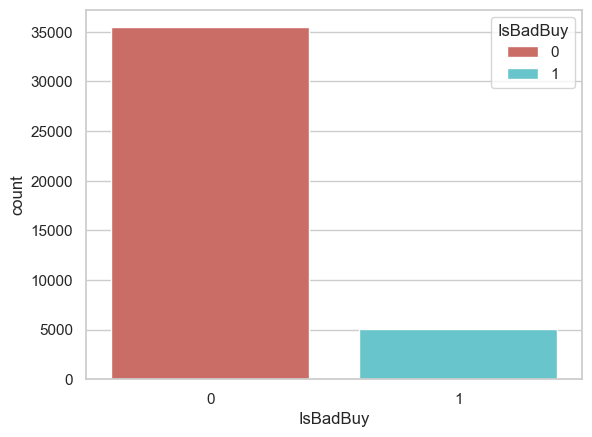

<Figure size 640x480 with 0 Axes>

In [8]:
sns.countplot(x='IsBadBuy',data=data, palette='hls', hue = 'IsBadBuy')
plt.show()
plt.savefig('count_plot')

In [9]:
#data.groupby('IsBadBuy').mean()
#data.groupby('IsBadBuy')[data.columns.difference(['PurchDate'])].mean()
data.groupby('IsBadBuy')[data.select_dtypes(include=['number']).columns].mean()

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,ID,VehOdo + rand_num
IsBadBuy,,,,,,,,,,,,,,,,,,,,
0,0.0,2005.436694,4.079143,1.500916,71076.971739,6303.885119,7553.224412,8700.260836,10072.845884,6277.951397,7537.081522,8960.570964,10343.674391,26823.284812,58049.447581,6800.451318,0.027020,1267.280976,3.448896e+08,71177.705796
1,1.0,2004.630903,4.926892,1.424568,74908.087927,5509.382259,6731.382324,7903.542251,9258.366239,5489.400760,6714.900599,8017.267440,9375.990606,22323.023711,58474.507410,6258.107546,0.025094,1368.198973,3.326909e+08,75006.654021


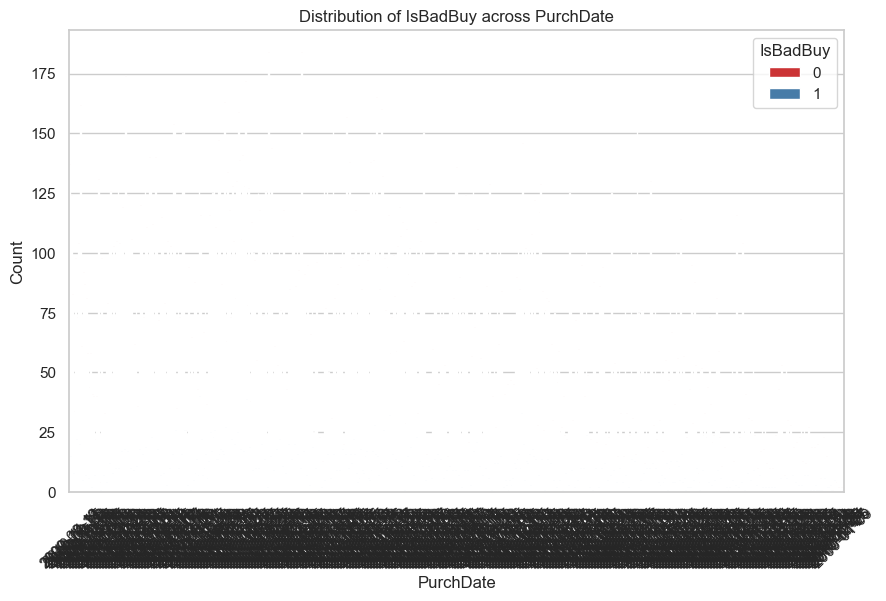

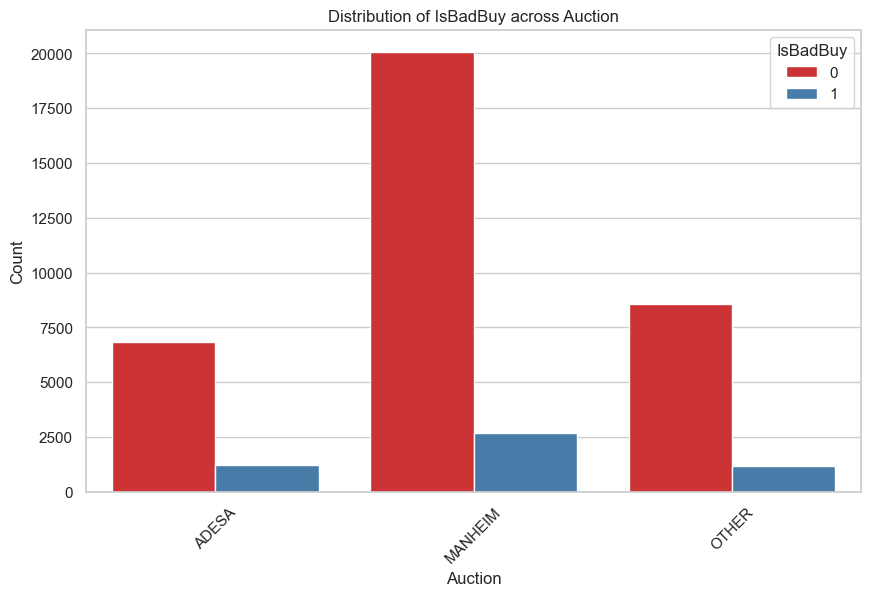

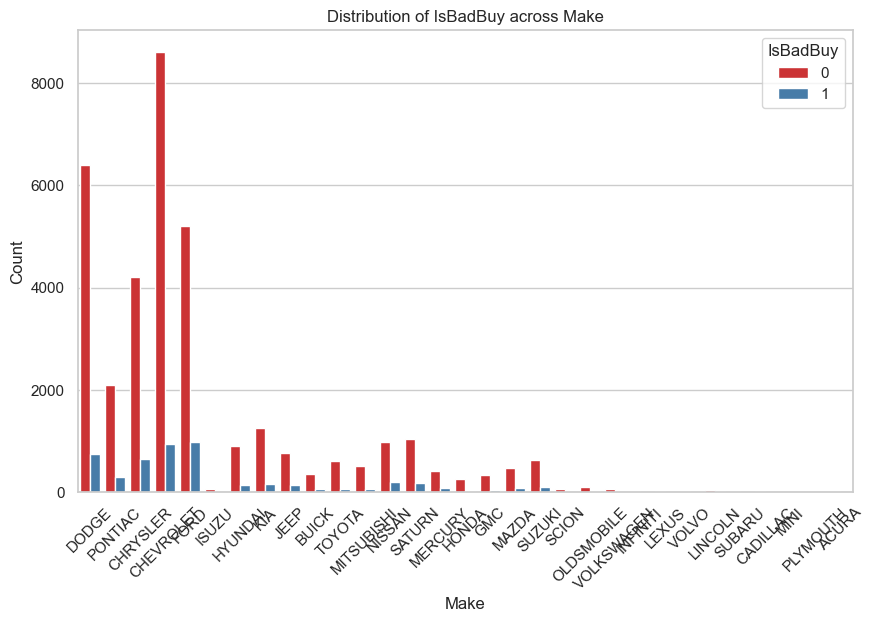

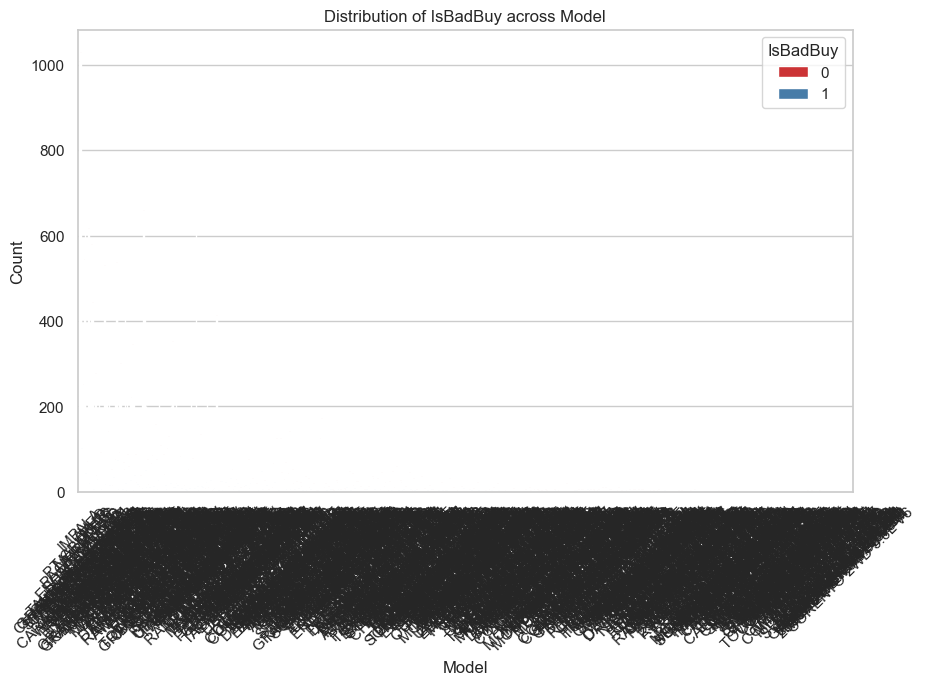

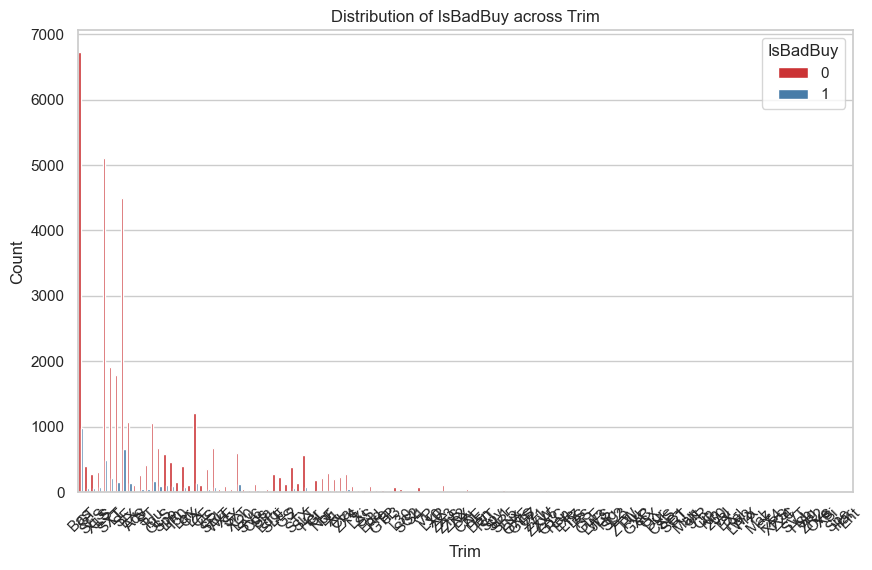

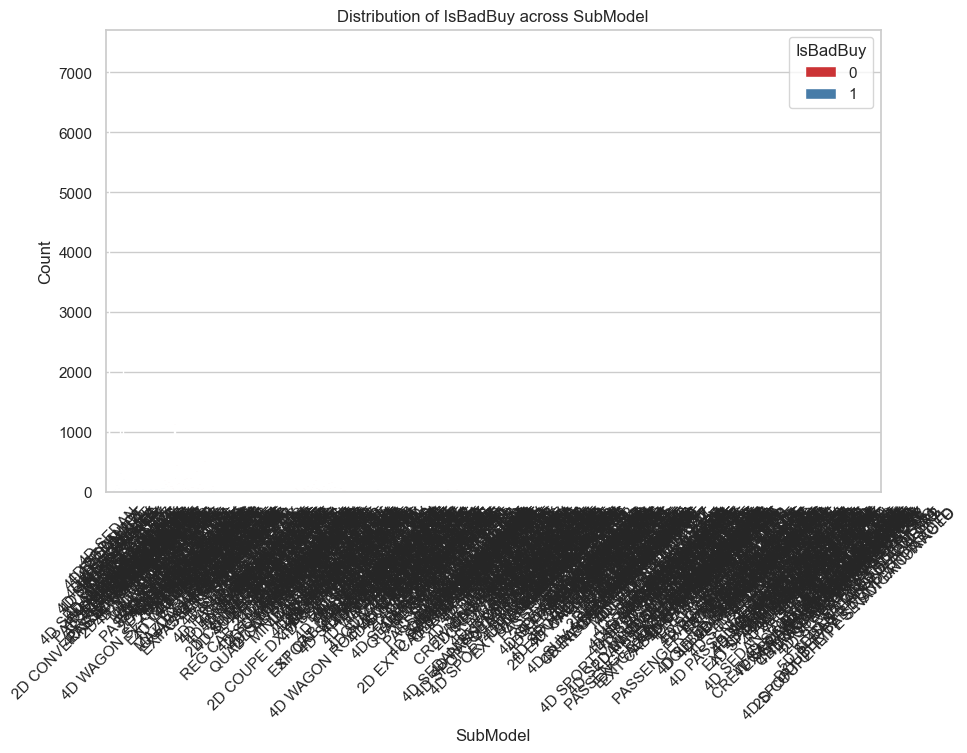

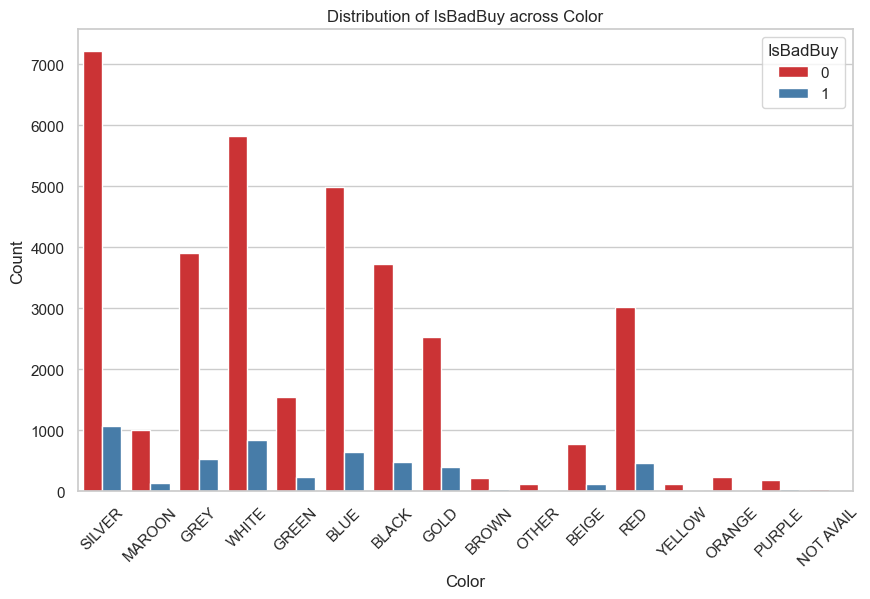

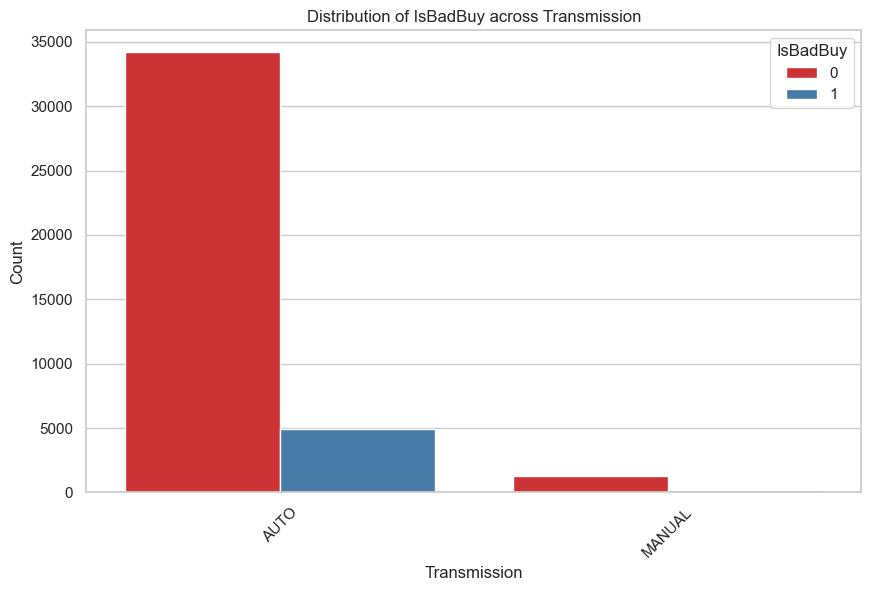

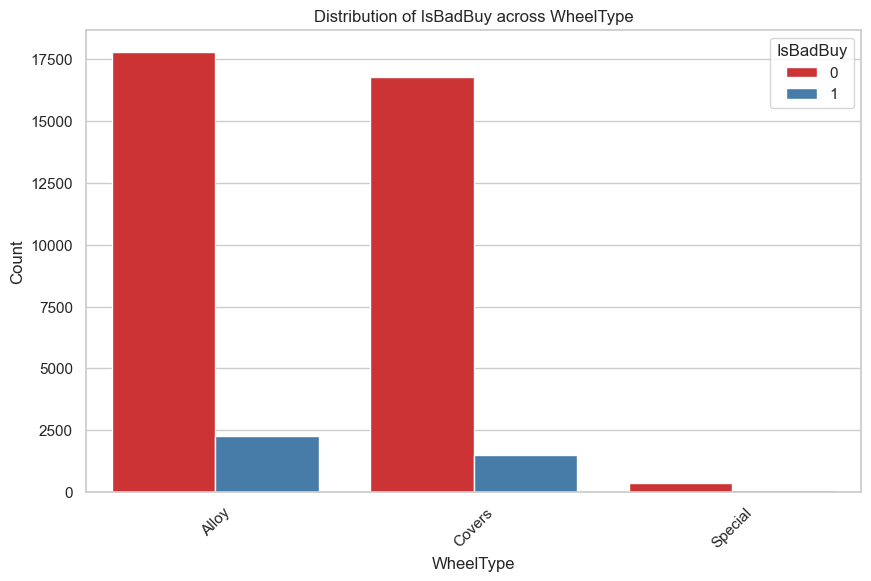

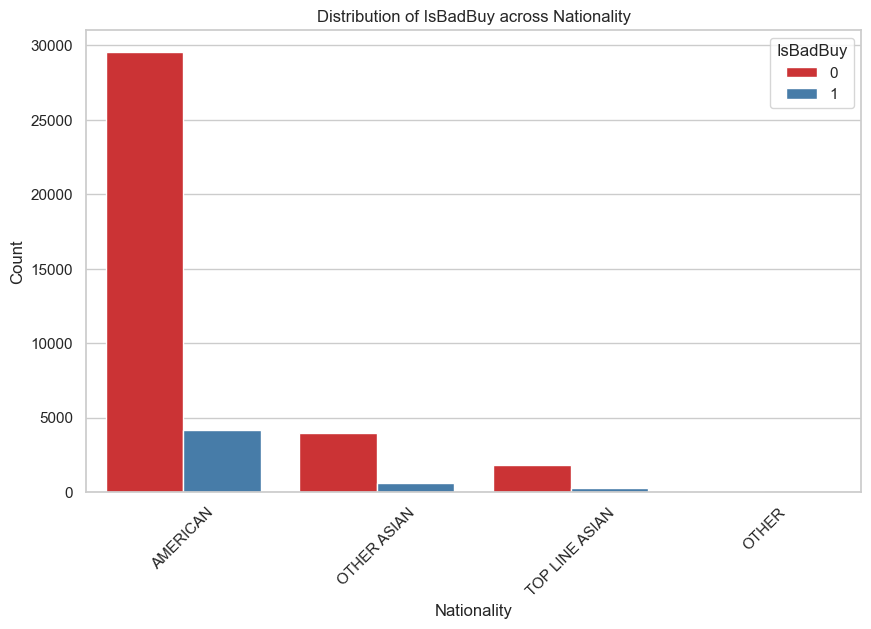

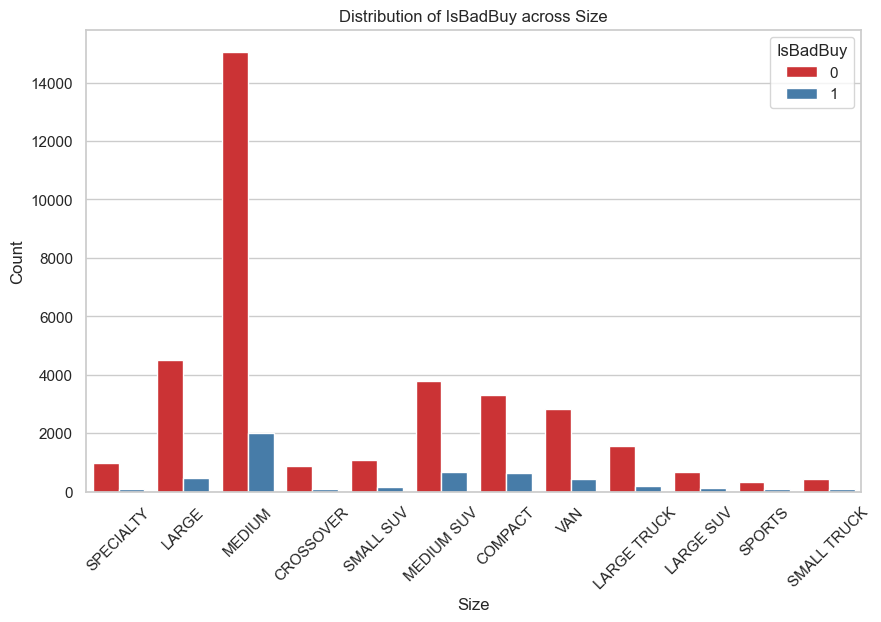

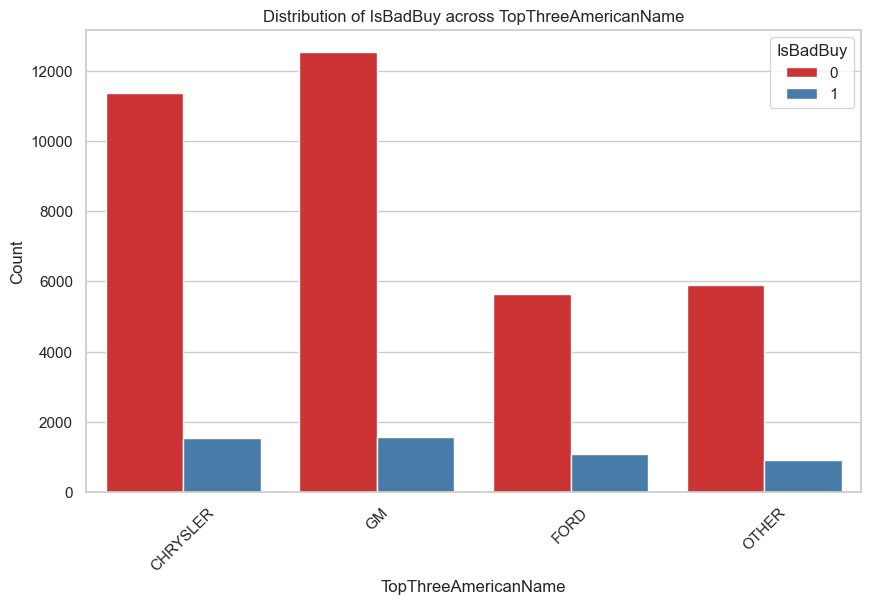

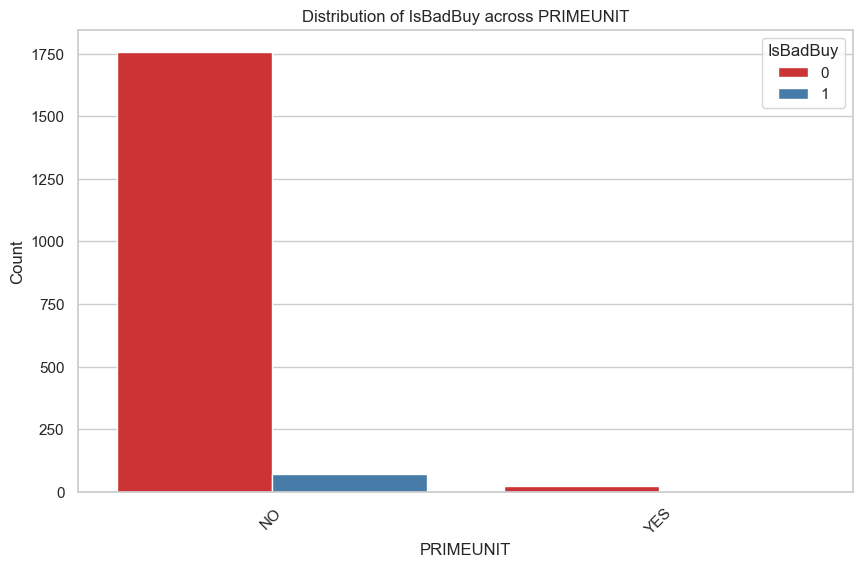

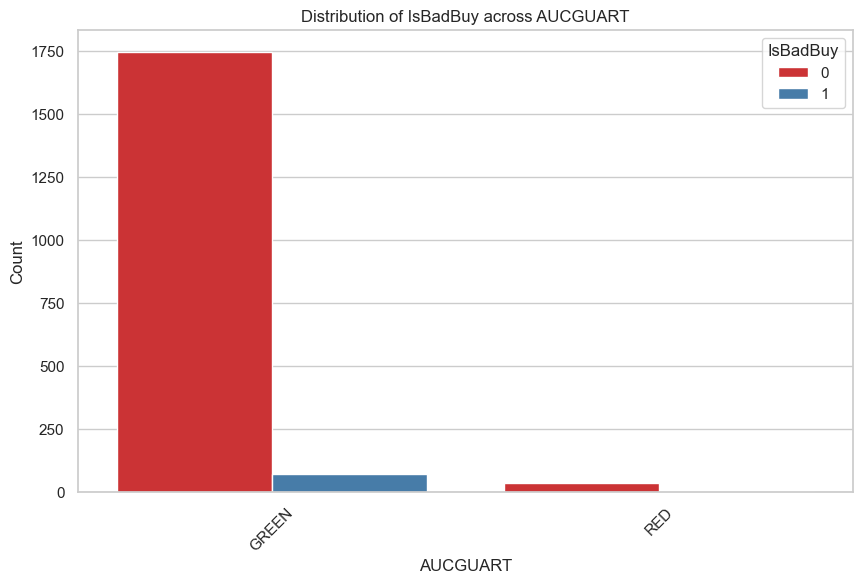

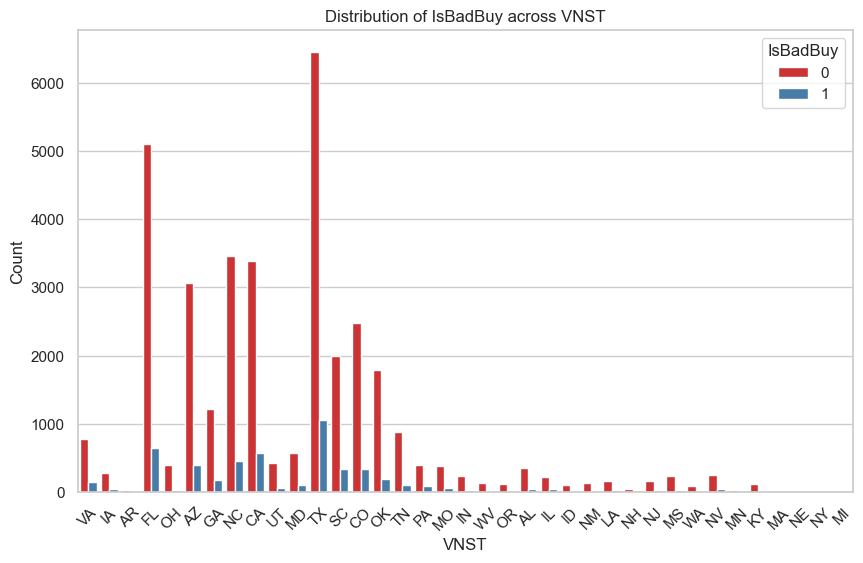

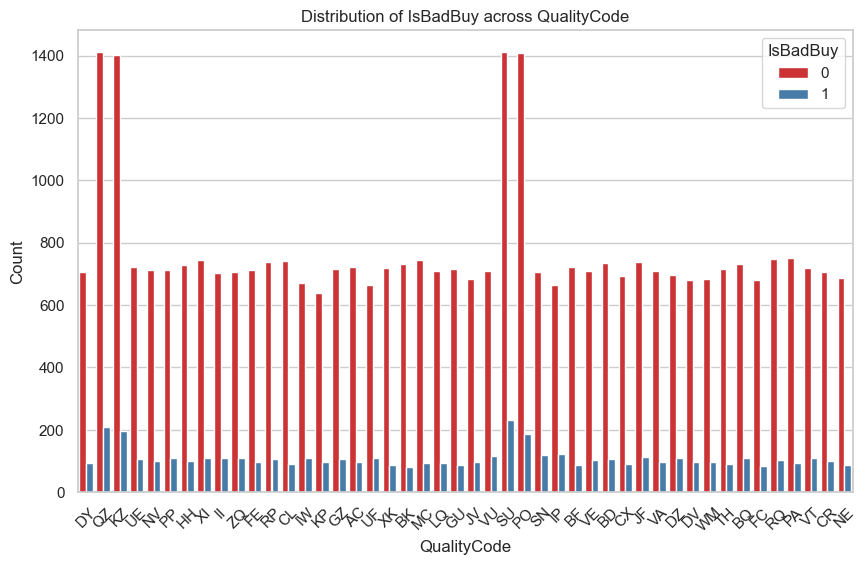

In [10]:
# Step 1: Identify categorical variables
categorical_vars = data.select_dtypes(include=['object', 'category']).columns

# Step 2: Explore target distribution across categorical variables
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=var, hue='IsBadBuy', palette='Set1')
    plt.title(f'Distribution of IsBadBuy across {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.legend(title='IsBadBuy', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

# Step 3: Handle date variables
date_vars = data.select_dtypes(include=['datetime']).columns

for date_var in date_vars:
    # Create a new DataFrame to calculate the target ratio over time
    data['date'] = data[date_var].dt.date  # Convert to date if necessary
    target_ratio = data.groupby('date')['IsBadBuy'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=target_ratio, x='date', y='IsBadBuy', marker='o')
    plt.title(f'Target Ratio of IsBadBuy over Time ({date_var})')
    plt.xlabel('Date')
    plt.ylabel('Target Ratio (IsBadBuy)')
    plt.xticks(rotation=45)
    plt.show()

In [11]:
### Frequency Encoding ###
columns_to_encode = ['Make', 'Model', 'SubModel', 'Trim', 'VNST', 'Color', 'Size', 'QualityCode']

# Frequency encoding and merging back to the original dataset
for column in columns_to_encode:
    # Calculate frequency encoding
    frequency_encoding = data[column].value_counts().reset_index()
    frequency_encoding.columns = [column, f'{column}_freq']  # Rename columns for merging
    
    # Merge frequency encoding back to the original dataset
    data = data.merge(frequency_encoding, on=column, how='left')


# Display the updated dataset with frequency encodings
print(data)

data = data.drop(columns=['Make', 'Model', 'SubModel', 'Trim', 'VNST', 'Color', 'Size', 'QualityCode', 'PurchDate', 'ID', 'VehOdo + rand_num'])

       IsBadBuy   PurchDate Auction  VehYear  VehicleAge       Make  \
0             0  2009-08-19   ADESA     2007           2      DODGE   
1             0  2009-10-13   ADESA     2004           5    PONTIAC   
2             1  2010-11-11   ADESA     2005           5   CHRYSLER   
3             0  2010-06-25   ADESA     2001           9  CHEVROLET   
4             0  2009-09-29   ADESA     2003           6       FORD   
...         ...         ...     ...      ...         ...        ...   
40511         0  2010-03-11   ADESA     2005           5       JEEP   
40512         0  2009-07-23   ADESA     2003           6      DODGE   
40513         0  2010-12-16   ADESA     2005           5  CHEVROLET   
40514         0  2009-01-08   ADESA     2006           3       FORD   
40515         0  2010-11-18   ADESA     2007           3  CHEVROLET   

                      Model Trim                      SubModel   Color  ...  \
0      CHARGER V6 2.7L V6 M  Bas                 4D SEDAN 2.7L  SILV

In [12]:
display(data)

,IsBadBuy,Auction,VehYear,VehicleAge,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,TopThreeAmericanName,...,IsOnlineSale,WarrantyCost,Make_freq,Model_freq,SubModel_freq,Trim_freq,VNST_freq,Color_freq,Size_freq,QualityCode_freq
0,0,ADESA,2007,2,AUTO,1.0,Alloy,47662,AMERICAN,CHRYSLER,...,0,975,7138,73,130.0,7702.0,933,8276.0,1080.0,799
1,0,ADESA,2004,5,AUTO,2.0,Covers,84500,AMERICAN,GM,...,0,2152,2383,473,303.0,470.0,309,1150.0,4981.0,1620
2,1,ADESA,2005,5,AUTO,NaN,NaN,72569,AMERICAN,CHRYSLER,...,0,1506,4842,1250,8.0,470.0,41,4435.0,17059.0,1597
3,0,ADESA,2001,9,AUTO,2.0,Covers,65329,AMERICAN,GM,...,0,2003,9547,1127,8377.0,7702.0,5747,6664.0,4981.0,828
4,0,ADESA,2003,6,AUTO,1.0,Alloy,73769,AMERICAN,FORD,...,0,1220,6200,655,78.0,358.0,433,1791.0,17059.0,812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40511,0,ADESA,2005,5,AUTO,1.0,Alloy,66741,AMERICAN,CHRYSLER,...,0,1606,909,153,230.0,490.0,3917,1791.0,4489.0,1597
40512,0,ADESA,2003,6,AUTO,1.0,Alloy,65797,AMERICAN,CHRYSLER,...,0,1515,7138,175,242.0,651.0,2807,5634.0,4489.0,1597
40513,0,ADESA,2005,5,AUTO,2.0,Covers,92924,AMERICAN,GM,...,0,1630,9547,175,219.0,5605.0,2807,2936.0,4489.0,819
40514,0,ADESA,2006,3,AUTO,2.0,Covers,81260,AMERICAN,FORD,...,0,983,6200,655,2145.0,5158.0,5747,8276.0,17059.0,825


In [13]:
### Train-Test Split ###

X = data.drop('IsBadBuy', axis=1)
y = data['IsBadBuy']

# Split the data
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
# Create K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

print(f"Train PCT : {len(X_train) / len(X) * 100:.1f}%")
print(f"Test PCT : {len(X_test) / len(X) * 100:.1f}%")
print(f"Kfold Count: {kfold.get_n_splits()}")

Train PCT : 70.0%
Test PCT : 30.0%
Kfold Count: 5


In [14]:
### Preprocessing Steps ###
from sklearn.base import BaseEstimator, TransformerMixin

class NovelCategoryHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            X[column] = X[column].astype('category').cat.add_categories('Novel').fillna('Novel')
        return X

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
#date_features = X.select_dtypes(include=['datetime']).columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normalizer', FunctionTransformer(lambda x: (x - x.min()) / (x.max() - x.min()))), # new
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('novel', NovelCategoryHandler()), #FunctionTransformer(lambda x: pd.Categorical(x).add_categories('Novel').fillna('Novel'))),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ], remainder='drop'  # Drop columns not specified, such as IDs
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('normalizer',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000200117E7CE0>)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice'...
       'Model_freq', 'SubModel_freq', 'Trim_freq', 'VNST_freq', 'Color_freq',
       'Size_freq', 'QualityCode_freq'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('novel',
                                                  NovelCategoryHandler()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['Auction', 'Transmission', 'WheelType', 'Nationality',
       'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART'],
      dtype='object'))])

In [15]:
### Random Forest model ###

seed = np.random.seed(1000)

rf_model = RandomForestClassifier(random_state=seed)

# Create a pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Define parameter distributions for random search
rf_param_grid = {
    'classifier__n_estimators': [100, 1000],  # equivalent to trees() in R
    'classifier__min_samples_leaf': [1, 20],  # equivalent to min_n() in R
    'classifier__min_samples_split': [2, 40],
    'classifier__max_depth': [1, 100],
    'classifier__min_weight_fraction_leaf': [0.0, 0.5]
    #'classifier_max_features': 'sqrt',
    #'classifier_max_leaf_nodes': randint(1,20)
    #'classfier_min_impurity_decrease': randint(0.0, 1.0)
}

#Valid parameters are:
#'bootstrap'
#'ccp_alpha'
#'class_weight'
#'criterion',
#'max_depth', 
#'max_features', 
#'max_leaf_nodes', 
#'max_samples', 
#'min_impurity_decrease', 
#'min_samples_leaf', 
#'min_samples_split', 
#'min_weight_fraction_leaf', 
#'monotonic_cst', 
#'n_estimators', 
#'n_jobs', 
#'oob_score', 
#'random_state', 
#'verbose', 
#'warm_start'

# Print parameter grid
print("Parameter Grid:")
for param, values in rf_param_grid.items():
    print(f"{param}: {values}")


Parameter Grid:
classifier__n_estimators: [100, 1000]
classifier__min_samples_leaf: [1, 20]
classifier__min_samples_split: [2, 40]
classifier__max_depth: [1, 100]
classifier__min_weight_fraction_leaf: [0.0, 0.5]


In [16]:
### Random Forest - Random Search ###

# Perform random search
random_search_RF = RandomizedSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    n_iter=5, 
    cv=kfold, 
    scoring='roc_auc',
    error_score='raise',
    n_jobs=-1,
    random_state=seed
)

random_search_RF.fit(X_train, y_train)

# Print results
print("Best parameters:", random_search_RF.best_params_)
print("Best ROC AUC score:", random_search_RF.best_score_)
# Show all results
#results = pd.DataFrame(grid_search.cv_results_)
results = pd.DataFrame(random_search_RF.cv_results_)
results = results.sort_values('rank_test_score')
print("\nAll results:")
print(results[['params', 'mean_test_score', 'std_test_score']].round(3))

# Best model
best_model_RF_rs = random_search_RF.best_estimator_

# Make predictions on test set
y_pred = best_model_RF_rs.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"Test set ROC AUC: {test_roc_auc:.4f}")

# Get feature importances
feature_importance = best_model_RF_rs.named_steps['classifier'].feature_importances_
# Feature importance II
feature_importance = best_model_RF_rs.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 random_search_RF.best_estimator_.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(random_search_RF))

Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 100}
Best ROC AUC score: 0.7507222705389522

All results:
                                              params  mean_test_score  \
2  {'classifier__n_estimators': 1000, 'classifier...            0.751   
3  {'classifier__n_estimators': 1000, 'classifier...            0.522   
0  {'classifier__n_estimators': 100, 'classifier_...            0.522   
1  {'classifier__n_estimators': 100, 'classifier_...            0.521   
4  {'classifier__n_estimators': 100, 'classifier_...            0.521   

   std_test_score  
2           0.009  
3           0.044  
0           0.044  
1           0.042  
4           0.042  
Test set ROC AUC: 0.6169

Top 10 important features:
                              feature  importance
33                    WheelType_Novel    0.262278
2                         WheelTypeI

In [17]:
### Random Forest - Grid Search ###

# Perform grid search
grid_search_RF = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=kfold, 
    #n_splits=5, 
    scoring='roc_auc', 
    error_score='raise',
    n_jobs=-1
    )

grid_search_RF.fit(X_train, y_train)

# Print results
print("Best parameters:", grid_search_RF.best_params_)
print("Best ROC AUC score:", grid_search_RF.best_score_)
# Show all results
results = pd.DataFrame(grid_search_RF.cv_results_)
results = results.sort_values('rank_test_score')
print("\nAll results:")
print(results[['params', 'mean_test_score', 'std_test_score']].round(3))

# Best model
best_model_RF_gs = grid_search_RF.best_estimator_

# Make predictions on test set
y_pred = best_model_RF_gs.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"Test set ROC AUC: {test_roc_auc:.4f}")

# Get feature importances
feature_importance = best_model_RF_gs.named_steps['classifier'].feature_importances_
# Feature importance II
feature_importance = best_model_RF_gs.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 best_model_RF_gs.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(grid_search_RF))

Best parameters: {'classifier__max_depth': 100, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 40, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 1000}
Best ROC AUC score: 0.7513831142638275

All results:
                                               params  mean_test_score  \
29  {'classifier__max_depth': 100, 'classifier__mi...            0.751   
25  {'classifier__max_depth': 100, 'classifier__mi...            0.751   
24  {'classifier__max_depth': 100, 'classifier__mi...            0.749   
28  {'classifier__max_depth': 100, 'classifier__mi...            0.747   
21  {'classifier__max_depth': 100, 'classifier__mi...            0.744   
20  {'classifier__max_depth': 100, 'classifier__mi...            0.739   
17  {'classifier__max_depth': 100, 'classifier__mi...            0.739   
16  {'classifier__max_depth': 100, 'classifier__mi...            0.730   
9   {'classifier__max_depth': 1, 'classifier__min_...            0.725   
13  {'c

In [18]:
### Random Forest - Bayesian Hyperparameter Optimization ###

# Define parameter distributions for random search
rf_param_space = {
    'classifier__n_estimators': Integer(100, 1000),  # equivalent to trees() in R
    'classifier__min_samples_leaf': Integer(1, 20),  # equivalent to min_n() in R
    'classifier__min_samples_split': Integer(2, 40),
    'classifier__max_depth': Integer(1, 100),
    'classifier__min_weight_fraction_leaf': Integer(0.0, 0.5),
}

# Print parameter space
print("Parameter Space:")
for param, space in rf_param_space.items():
    print(f"{param}: {space}")

### Perform Bayesian optimization ###
bayes_search_RF = BayesSearchCV(
    rf_pipeline,
    rf_param_space,
    n_iter=5,  # number of parameter settings that are sampled
    cv=kfold,
    scoring='roc_auc',
    error_score='raise',
    n_jobs=-1,
    random_state=seed,
    verbose=1
)

# Fit to training dat
bayes_search_RF.fit(X_train, y_train)

# Print results
print("\nBest parameters:", bayes_search_RF.best_params_)
print("Best ROC AUC score:", round(bayes_search_RF.best_score_, 3))

# Results
results = pd.DataFrame(bayes_search_RF.cv_results_)
results = results.sort_values('rank_test_score')
print("\nTop 10 results:")
print(results[['params', 'mean_test_score', 'std_test_score']].head(10).round(3))

# Best Model
best_model_RF_bo = bayes_search_RF.best_estimator_

# Test Predictions
y_pred = best_model_RF_bo.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")

# Feature Importance
feature_importance = best_model_RF_bo.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 best_model_RF_bo.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(bayes_search_RF))

Parameter Space:
classifier__n_estimators: Integer(low=100, high=1000, prior='uniform', transform='identity')
classifier__min_samples_leaf: Integer(low=1, high=20, prior='uniform', transform='identity')
classifier__min_samples_split: Integer(low=2, high=40, prior='uniform', transform='identity')
classifier__max_depth: Integer(low=1, high=100, prior='uniform', transform='identity')
classifier__min_weight_fraction_leaf: Integer(low=0.0, high=0.5, prior='uniform', transform='identity')
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: OrderedDict({'classifier__max_depth': 78, 'classifier__min_samples_leaf': 18, 'classifier__min_samples_split': 23, 'classifier__min_weight_fraction_leaf': 0, 'classifier__n_estimators': 811})
Best RO

In [19]:
### XGB Model ###
seed = np.random.seed(999)

# Create XGBoost model
xgb_model = XGBClassifier(random_state=seed, eval_metric='logloss')

# Create a pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # reuse the preprocessor from RF model
    ('classifier', xgb_model)
])

# Define parameter grid
xgb_param_grid = {
    'classifier__n_estimators': [100, 4000],  # equivalent to trees()
    'classifier__max_depth': [1, 100],  # equivalent to tree_depth()
    'classifier__min_child_weight': [1, 20],  # equivalent to min_n()
    'classifier__learning_rate': [0.01, 1.0]  # equivalent to learn_rate()
}

# Print parameter grid
print("Parameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"{param}: {values}")

Parameter Grid:
classifier__n_estimators: [100, 4000]
classifier__max_depth: [1, 100]
classifier__min_child_weight: [1, 20]
classifier__learning_rate: [0.01, 1.0]


In [20]:
### XGBoost - Random Search ###

# Perform random search
random_search_XGB = RandomizedSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    n_iter=5,  # number of parameter settings that are sampled
    cv=kfold, 
    scoring='roc_auc',
    error_score='raise',
    n_jobs=-1,
    random_state=seed
)

random_search_XGB.fit(X_train, y_train)

# Print results
print("\nBest parameters:", random_search_XGB.best_params_)
print("Best ROC AUC score:", round(random_search_XGB.best_score_, 3))

# Show all results
#results = pd.DataFrame(grid_search.cv_results_)
results = pd.DataFrame(random_search_XGB.cv_results_)
results = results.sort_values('rank_test_score')
print("\nAll results:")
print(results[['params', 'mean_test_score', 'std_test_score']].round(3))

# Get best model
best_model_XGB_rs = random_search_XGB.best_estimator_

# Make predictions on test set
y_pred = best_model_XGB_rs.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")

# Feature importance
feature_importance = best_model_XGB_rs.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 best_model_XGB_rs.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(random_search_XGB))


Best parameters: {'classifier__n_estimators': 100, 'classifier__min_child_weight': 20, 'classifier__max_depth': 1, 'classifier__learning_rate': 1.0}
Best ROC AUC score: 0.744

All results:
                                              params  mean_test_score  \
1  {'classifier__n_estimators': 100, 'classifier_...            0.744   
2  {'classifier__n_estimators': 4000, 'classifier...            0.731   
4  {'classifier__n_estimators': 4000, 'classifier...            0.728   
3  {'classifier__n_estimators': 100, 'classifier_...            0.707   
0  {'classifier__n_estimators': 100, 'classifier_...            0.700   

   std_test_score  
1           0.013  
2           0.011  
4           0.009  
3           0.011  
0           0.009  

Test set ROC AUC: 0.620

Top 10 important features:
            feature  importance
33  WheelType_Novel    0.751906
1        VehicleAge    0.051983
45     PRIMEUNIT_NO    0.030793
18       Model_freq    0.018116
14         VehBCost    0.015994
21    

In [21]:
### XGBoost - Grid Search ###

# Perform grid search
grid_search_XGB = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=kfold, 
    #n_splits=5, 
    scoring='roc_auc', 
    error_score='raise',
    n_jobs=-1
    )

grid_search_XGB.fit(X_train, y_train)

# Print results
print("Best parameters:", grid_search_XGB.best_params_)
print("Best ROC AUC score:", grid_search_XGB.best_score_)
# Show all results
results = pd.DataFrame(grid_search_XGB.cv_results_)
results = results.sort_values('rank_test_score')
print("\nAll results:")
print(results[['params', 'mean_test_score', 'std_test_score']].round(3))

# Best model
best_model_XGB_gs = grid_search_XGB.best_estimator_

# Make predictions on test set
y_pred = best_model_XGB_gs.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"Test set ROC AUC: {test_roc_auc:.4f}")

# Get feature importances
feature_importance = best_model_XGB_gs.named_steps['classifier'].feature_importances_
# Feature importance II
feature_importance = best_model_XGB_gs.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 best_model_XGB_gs.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(grid_search_XGB))

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 1, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 4000}
Best ROC AUC score: 0.7520926007477924

All results:
                                               params  mean_test_score  \
1   {'classifier__learning_rate': 0.01, 'classifie...            0.752   
3   {'classifier__learning_rate': 0.01, 'classifie...            0.751   
8   {'classifier__learning_rate': 1.0, 'classifier...            0.745   
10  {'classifier__learning_rate': 1.0, 'classifier...            0.744   
6   {'classifier__learning_rate': 0.01, 'classifie...            0.740   
9   {'classifier__learning_rate': 1.0, 'classifier...            0.731   
11  {'classifier__learning_rate': 1.0, 'classifier...            0.731   
7   {'classifier__learning_rate': 0.01, 'classifie...            0.728   
5   {'classifier__learning_rate': 0.01, 'classifie...            0.728   
4   {'classifier__learning_rate': 0.01, 'classifie...    

In [22]:
### Bayesian Optimization of Hyperparameter Tuning for XGBoost ###

# Define parameter space for Bayesian optimization
xgb_param_space = {
    'classifier__n_estimators': Integer(100, 4000),
    'classifier__max_depth': Integer(1, 40),
    'classifier__min_child_weight': Integer(1, 20),
    'classifier__learning_rate': Real(0.01, 1.0, prior='log-uniform')
}

# Print the parameter space
print("Parameter Space:")
for param, space in xgb_param_space.items():
    print(f"{param}: {space}")

# Perform Bayesian optimization
bayes_search_XGB = BayesSearchCV(
    xgb_pipeline,
    xgb_param_space,
    n_iter=5,  # number of parameter settings that are sampled
    cv=kfold,
    scoring='roc_auc',
    error_score='raise',
    n_jobs=-1,
    random_state=seed,
    verbose=1
)

# Fit to training dat
bayes_search_XGB.fit(X_train, y_train)

# Print results
print("\nBest parameters:", bayes_search_XGB.best_params_)
print("Best ROC AUC score:", round(bayes_search_XGB.best_score_, 3))

# Results
results = pd.DataFrame(bayes_search_XGB.cv_results_)
results = results.sort_values('rank_test_score')
print("\nTop 10 results:")
print(results[['params', 'mean_test_score', 'std_test_score']].head(10).round(3))

# Best Model
best_model_XGB_bo = bayes_search_XGB.best_estimator_

# Test Predictions
y_pred = best_model_XGB_bo.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")

# Feature Importance
feature_importance = best_model_XGB_bo.named_steps['classifier'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 best_model_XGB_bo.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nTop 10 important features:")
print(importance_df.head(10))
print(search_results(bayes_search_XGB))      

Parameter Space:
classifier__n_estimators: Integer(low=100, high=4000, prior='uniform', transform='identity')
classifier__max_depth: Integer(low=1, high=40, prior='uniform', transform='identity')
classifier__min_child_weight: Integer(low=1, high=20, prior='uniform', transform='identity')
classifier__learning_rate: Real(low=0.01, high=1.0, prior='log-uniform', transform='identity')
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: OrderedDict({'classifier__learning_rate': 0.020674314197955925, 'classifier__max_depth': 10, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 3701})
Best ROC AUC score: 0.721

Top 10 results:
                                              params  mean_test_score  \
1  {'classifier__learnin

In [23]:
def evaluate_model(best_model, X_test, y_test):
    """
    Evaluate the XGBoost model using various metrics.
    
    :param best_model: Trained XGBoost model (from BayesSearchCV)
    :param X_test: Test features
    :param y_test: True labels
    :return: Dictionary of all metrics
    """
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification

    metrics = {}

    # Classification metrics
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    metrics['Precision'] = precision_score(y_test, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_test, y_pred, average='weighted')
    metrics['F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    metrics['ROC AUC'] = roc_auc_score(y_test, y_prob)
    metrics['Log Loss'] = log_loss(y_test, y_prob)
    metrics['Brier Score'] = brier_score_loss(y_test, y_prob)
    metrics['Matthews Correlation Coefficient'] = matthews_corrcoef(y_test, y_pred)
    metrics['Cohen\'s Kappa'] = cohen_kappa_score(y_test, y_pred)
    metrics['Jaccard Score'] = jaccard_score(y_test, y_pred, average='weighted')
    metrics['Hamming Loss'] = hamming_loss(y_test, y_pred)

    # Regression-like metrics (can be used for probabilistic outputs)
    metrics['Mean Squared Error'] = mean_squared_error(y_test, y_prob)
    metrics['Root Mean Squared Error'] = np.sqrt(metrics['Mean Squared Error'])
    metrics['Mean Absolute Error'] = mean_absolute_error(y_test, y_prob)
    metrics['R-squared'] = r2_score(y_test, y_prob)
    metrics['Explained Variance Score'] = explained_variance_score(y_test, y_prob)
    metrics['Max Error'] = max_error(y_test, y_prob)
    
    # Additional custom metrics
    metrics['Mean Bias Error'] = np.mean(y_prob - y_test)
    metrics['Median Absolute Error'] = np.median(np.abs(y_prob - y_test))

    # Confusion matrix derived metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    metrics['True Positives'] = tp
    metrics['True Negatives'] = tn
    metrics['False Positives'] = fp
    metrics['False Negatives'] = fn
    metrics['Sensitivity (True Positive Rate)'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['Specificity (True Negative Rate)'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['Fall-out (False Positive Rate)'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['False Negative Rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return metrics

In [24]:
### Evaluation ###

In [25]:
# RF - Grid Search Eval
metrics = evaluate_model(best_model_RF_gs, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8987
Precision: 0.8916
Recall: 0.8987
F1 Score: 0.8736
ROC AUC: 0.7634
Log Loss: 0.3050
Brier Score: 0.0864
Matthews Correlation Coefficient: 0.4115
Cohen's Kappa: 0.3358
Jaccard Score: 0.8124
Hamming Loss: 0.1013
Mean Squared Error: 0.0864
Root Mean Squared Error: 0.2939
Mean Absolute Error: 0.1769
R-squared: 0.2098
Explained Variance Score: 0.2099
Max Error: 0.9845
Mean Bias Error: -0.0027
Median Absolute Error: 0.0942
True Positives: 367.0000
True Negatives: 10557.0000
False Positives: 80.0000
False Negatives: 1151.0000
Sensitivity (True Positive Rate): 0.2418
Specificity (True Negative Rate): 0.9925
Fall-out (False Positive Rate): 0.0075
False Negative Rate: 0.7582


In [26]:
# RF - Random Search Eval
metrics = evaluate_model(best_model_RF_rs, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8988
Precision: 0.8920
Recall: 0.8988
F1 Score: 0.8735
ROC AUC: 0.7643
Log Loss: 0.3049
Brier Score: 0.0864
Matthews Correlation Coefficient: 0.4120
Cohen's Kappa: 0.3355
Jaccard Score: 0.8124
Hamming Loss: 0.1012
Mean Squared Error: 0.0864
Root Mean Squared Error: 0.2939
Mean Absolute Error: 0.1772
R-squared: 0.2096
Explained Variance Score: 0.2096
Max Error: 0.9847
Mean Bias Error: -0.0026
Median Absolute Error: 0.0949
True Positives: 366.0000
True Negatives: 10559.0000
False Positives: 78.0000
False Negatives: 1152.0000
Sensitivity (True Positive Rate): 0.2411
Specificity (True Negative Rate): 0.9927
Fall-out (False Positive Rate): 0.0073
False Negative Rate: 0.7589


In [27]:
# RF - Bayesian Optimization Eval 
metrics = evaluate_model(best_model_RF_bo, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8991
Precision: 0.8928
Recall: 0.8991
F1 Score: 0.8739
ROC AUC: 0.7637
Log Loss: 0.3049
Brier Score: 0.0863
Matthews Correlation Coefficient: 0.4145
Cohen's Kappa: 0.3372
Jaccard Score: 0.8129
Hamming Loss: 0.1009
Mean Squared Error: 0.0863
Root Mean Squared Error: 0.2938
Mean Absolute Error: 0.1772
R-squared: 0.2102
Explained Variance Score: 0.2103
Max Error: 0.9837
Mean Bias Error: -0.0023
Median Absolute Error: 0.0944
True Positives: 367.0000
True Negatives: 10562.0000
False Positives: 75.0000
False Negatives: 1151.0000
Sensitivity (True Positive Rate): 0.2418
Specificity (True Negative Rate): 0.9929
Fall-out (False Positive Rate): 0.0071
False Negative Rate: 0.7582


In [28]:
# XGB - Grid Search Eval
metrics = evaluate_model(best_model_XGB_gs, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8951
Precision: 0.8816
Recall: 0.8951
F1 Score: 0.8714
ROC AUC: 0.7683
Log Loss: 0.3068
Brier Score: 0.0876
Matthews Correlation Coefficient: 0.3882
Cohen's Kappa: 0.3289
Jaccard Score: 0.8088
Hamming Loss: 0.1049
Mean Squared Error: 0.0876
Root Mean Squared Error: 0.2959
Mean Absolute Error: 0.1788
R-squared: 0.1988
Explained Variance Score: 0.1988
Max Error: 0.9743
Mean Bias Error: 0.0003
Median Absolute Error: 0.0916
True Positives: 376.0000
True Negatives: 10504.0000
False Positives: 133.0000
False Negatives: 1142.0000
Sensitivity (True Positive Rate): 0.2477
Specificity (True Negative Rate): 0.9875
Fall-out (False Positive Rate): 0.0125
False Negative Rate: 0.7523


In [29]:
# XGB - Random Search Eval
metrics = evaluate_model(best_model_XGB_rs, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8961
Precision: 0.8835
Recall: 0.8961
F1 Score: 0.8726
ROC AUC: 0.7648
Log Loss: 0.3068
Brier Score: 0.0875
Matthews Correlation Coefficient: 0.3956
Cohen's Kappa: 0.3352
Jaccard Score: 0.8102
Hamming Loss: 0.1039
Mean Squared Error: 0.0875
Root Mean Squared Error: 0.2958
Mean Absolute Error: 0.1766
R-squared: 0.1992
Explained Variance Score: 0.1993
Max Error: 0.9821
Mean Bias Error: 0.0013
Median Absolute Error: 0.0882
True Positives: 382.0000
True Negatives: 10510.0000
False Positives: 127.0000
False Negatives: 1136.0000
Sensitivity (True Positive Rate): 0.2516
Specificity (True Negative Rate): 0.9881
Fall-out (False Positive Rate): 0.0119
False Negative Rate: 0.7484


In [30]:
# XGB - Bayesian Optimization Eval
metrics = evaluate_model(best_model_XGB_bo, X_test, y_test)
for metric, value in metrics.items():
     print(f"{metric}: {value:.4f}")

Accuracy: 0.8999
Precision: 0.8908
Recall: 0.8999
F1 Score: 0.8773
ROC AUC: 0.7365
Log Loss: 0.3907
Brier Score: 0.0901
Matthews Correlation Coefficient: 0.4243
Cohen's Kappa: 0.3599
Jaccard Score: 0.8157
Hamming Loss: 0.1001
Mean Squared Error: 0.0901
Root Mean Squared Error: 0.3001
Mean Absolute Error: 0.1223
R-squared: 0.1757
Explained Variance Score: 0.2023
Max Error: 0.9999
Mean Bias Error: -0.0539
Median Absolute Error: 0.0136
True Positives: 406.0000
True Negatives: 10532.0000
False Positives: 105.0000
False Negatives: 1112.0000
Sensitivity (True Positive Rate): 0.2675
Specificity (True Negative Rate): 0.9901
Fall-out (False Positive Rate): 0.0099
False Negative Rate: 0.7325


In [61]:
import os

def built_in_feature_importance(pipeline, X, model_name, top_n=10):
    # Get the preprocessor and classifier from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    classifier = pipeline.named_steps['classifier']
    
    # Get feature names
    feature_names = (numeric_features.tolist() + 
                     preprocessor.named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())
    
    # Get feature importances
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])
    else:
        raise ValueError("Model doesn't have feature_importances_ or coef_ attribute")
    
    # Sort features by importance
    indices = np.argsort(importances)[-top_n:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]
    
    # Create a bar plot of feature importances
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.bar(range(top_n), top_importances)
    plt.xticks(range(top_n), top_features, rotation=90)
    plt.tight_layout()
    
    # Create a 'plots' directory if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Save the plot
    plt.savefig(f'plots/feature_importance_{model_name.replace(" ", "_")}.png')
    plt.close()
    
    return top_features, top_importances

def analyze_all_models(models_dict, X, top_n=10):
    results = {}
    for name, model in models_dict.items():
        print(f"\nAnalyzing {name}...")
        top_features, importances = built_in_feature_importance(model, X, name, top_n=top_n)
        results[name] = list(zip(top_features, importances))
        print(f"Top {top_n} features for {name}:")
        for feature, importance in results[name]:
            print(f"{feature}: {importance:.4f}")
    return results

In [63]:
import pandas as pd
import numpy as np

# Set the option to suppress the warning (optional)
pd.set_option('future.no_silent_downcasting', True)

# Create a dictionary of all models
all_models = {
    "RF Grid Search": best_model_RF_gs,
    "RF Random Search": best_model_RF_rs,
    "RF Bayesian Optimization": best_model_RF_bo,
    "XGB Grid Search": best_model_XGB_gs,
    "XGB Random Search": best_model_XGB_rs,
    "XGB Bayesian Optimization": best_model_XGB_bo
}

# Run the analysis
results = analyze_all_models(all_models, X_test)

# Compare top features across models
all_top_features = set()
for model_results in results.values():
    all_top_features.update([feature for feature, _ in model_results])

# Convert the set to a sorted list
all_top_features = sorted(list(all_top_features))

comparison_df = pd.DataFrame(index=all_top_features, columns=all_models.keys())

for model_name, model_results in results.items():
    for feature, importance in model_results:
        comparison_df.loc[feature, model_name] = importance

# Fill NaN with 0 and infer correct data types
comparison_df = comparison_df.fillna(0).infer_objects(copy=False)

# Calculate the sum of importances across all models
comparison_df['Total Importance'] = comparison_df.sum(axis=1)

# Sort by the total importance
comparison_df = comparison_df.sort_values(by='Total Importance', ascending=False)

# Drop the 'Total Importance' column after sorting
comparison_df = comparison_df.drop('Total Importance', axis=1)

print("\nComparison of top features across all models:")
print(comparison_df)

print("\nFeature importance plots have been saved in the 'plots' directory.")


Analyzing RF Grid Search...
Top 10 features for RF Grid Search:
WheelType_Novel: 0.2624
WheelTypeID: 0.0746
WheelType_Alloy: 0.0538
VehBCost: 0.0383
VehOdo: 0.0358
MMRAcquisitionAuctionCleanPrice: 0.0326
MMRAcquisitionAuctionAveragePrice: 0.0312
MMRCurrentAuctionAveragePrice: 0.0303
MMRCurrentAuctionCleanPrice: 0.0295
VehicleAge: 0.0271

Analyzing RF Random Search...
Top 10 features for RF Random Search:
WheelType_Novel: 0.2623
WheelTypeID: 0.0769
WheelType_Alloy: 0.0489
VehBCost: 0.0399
VehOdo: 0.0353
MMRAcquisitionAuctionCleanPrice: 0.0317
MMRAcquisitionAuctionAveragePrice: 0.0312
MMRCurrentAuctionAveragePrice: 0.0301
MMRCurrentAuctionCleanPrice: 0.0291
VehicleAge: 0.0271

Analyzing RF Bayesian Optimization...
Top 10 features for RF Bayesian Optimization:
WheelType_Novel: 0.2440
WheelTypeID: 0.0766
WheelType_Alloy: 0.0522
VehBCost: 0.0409
VehOdo: 0.0362
MMRAcquisitionAuctionCleanPrice: 0.0326
MMRAcquisitionAuctionAveragePrice: 0.0318
MMRCurrentAuctionAveragePrice: 0.0308
MMRCurrentA